In [14]:
import os
import copy
import math
import typing
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch

figure_path = '/Users/davidfarache/Documents/ML-ToolBox/VisionTransformers/TransformerFiles'

# Position Embeeding

Mountain at Dusk is H = 60 and W = 100 pixels.




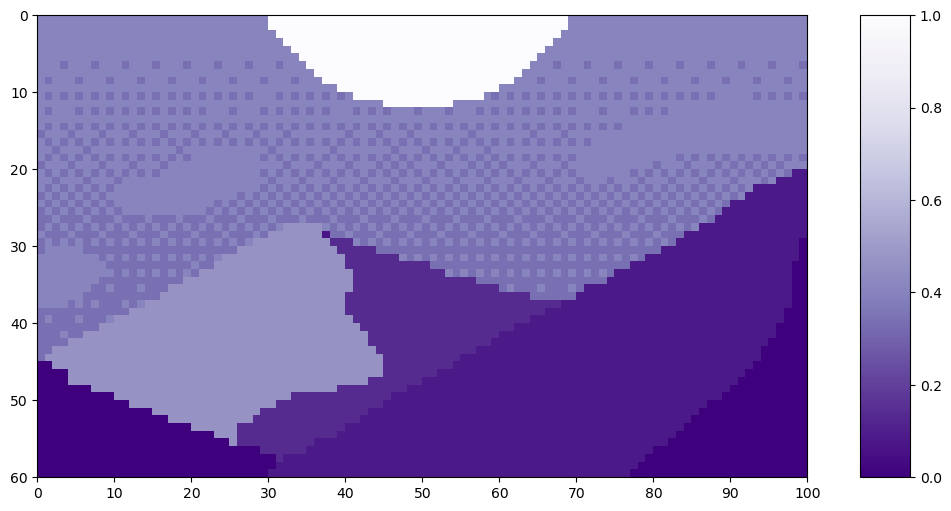

In [15]:
# Transformers are invariant to the order of the tokens (order should matter for iamge/words)
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

There will be 15 patches, each 20 by 20.




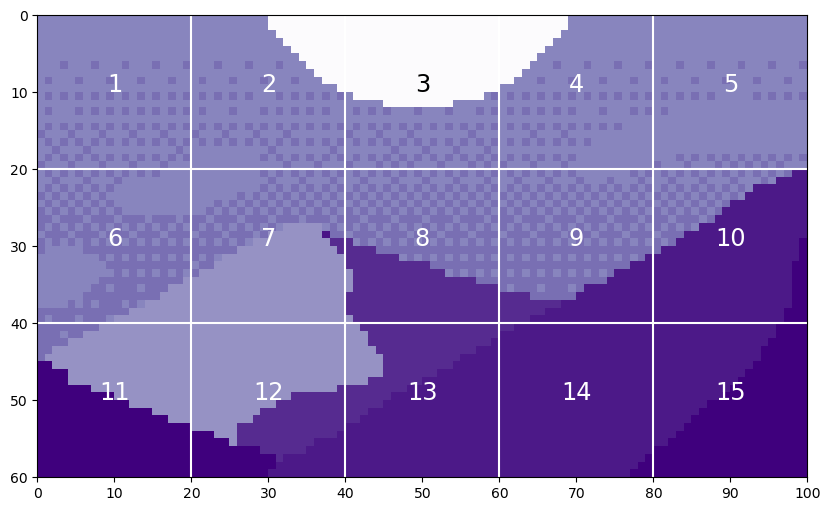

In [16]:
P = 20
N = int((H*W)/(P**2))
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.clim([0,1])
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight')

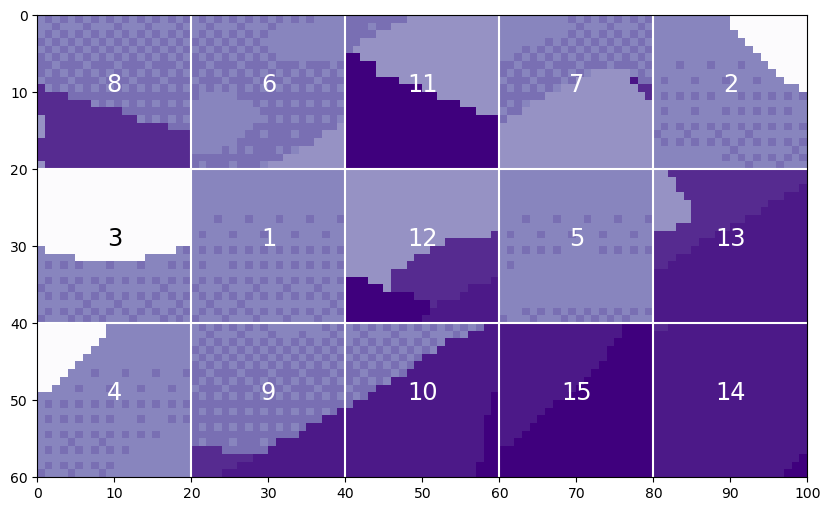

In [17]:
# Scrambled plot is processed same by transfomer but obviusly not that same
scramble_order = np.random.permutation(N)
left_x = np.tile(np.arange(0, W-P+1, 20), 3)
right_x = np.tile(np.arange(P, W+1, 20), 3)
top_y = np.repeat(np.arange(0, H-P+1, 20), 5)
bottom_y = np.repeat(np.arange(P, H+1, 20), 5)

scramble = np.zeros_like(mountains)
for i in range(N):
    t = scramble_order[i]
    scramble[top_y[i]:bottom_y[i], left_x[i]:right_x[i]] = mountains[top_y[t]:bottom_y[t], left_x[t]:right_x[t]]
    
fig = plt.figure(figsize=(10,6))
plt.imshow(scramble, cmap='Purples_r')
plt.clim([0,1])
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(N):
    plt.text(x_text[i], y_text[i], str(scramble_order[i]+1), color='w', fontsize='xx-large', ha='center')
    
i3 = np.where(scramble_order==2)[0][0]
plt.text(x_text[i3], y_text[i3], str(scramble_order[i3]+1), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_scrambled_patches.png'), bbox_inches='tight')

# Attention is Invariant to Order

In [18]:
# Plot image based on location of tokens
def mat_plot(matrix, title):
    up_clim = max(np.abs(matrix.flatten()))
    low_clim = min(np.abs(matrix.flatten()))
    y, x = matrix.shape
    im = plt.imshow(matrix, cmap='viridis')
    plt.xticks(ticks=np.arange(x));
    plt.yticks(ticks=np.arange(y));
    plt.title(title)
    plt.vlines(np.arange(0.5, x-0.5, 1), -0.5, y-0.5, colors='#DDDDDD')
    plt.hlines(np.arange(0.5, y-0.5, 1), -0.5, x-0.5, colors='#DDDDDD')

    ## Adding Value Labels
    for i in range(y):
        for j in range(x):
            if matrix[i,j]==0: #Don't label if it's zero
                pass
            elif np.abs(matrix[i,j]) > low_clim + ((up_clim-low_clim)/2):
                plt.text(j, i, round(matrix[i, j], 2), ha='center', va='center', color='k', fontsize=12)
            else:
                plt.text(j, i, round(matrix[i, j], 2), ha='center', va='center', color='w', fontsize=12)

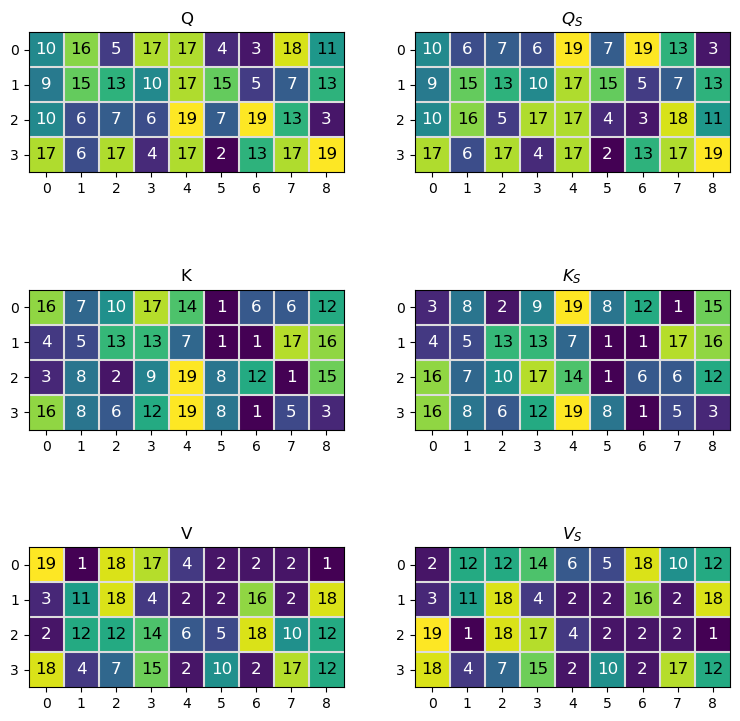

In [19]:
# Swap tokens in position 0 and 2
n_tokens = 4
l_tokens = 9
shape = n_tokens, l_tokens
mx = 20 #max integer for generated matricies

# Generate Normal Matricies
np.random.seed(21)
Q = np.random.randint(1, mx, shape)
K = np.random.randint(1, mx, shape)
V = np.random.randint(1, mx, shape)

# Generate Row-Swapped Matricies
swapQ = copy.deepcopy(Q)
swapQ[[0, 2]] = swapQ[[2, 0]]
swapK = copy.deepcopy(K)
swapK[[0, 2]] = swapK[[2, 0]]
swapV = copy.deepcopy(V)
swapV[[0, 2]] = swapV[[2, 0]]

# Plot Matricies
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2.0)
plt.subplot(3, 2, 1)
mat_plot(Q, 'Q')
plt.subplot(3, 2, 2)
mat_plot(swapQ, r'$Q_S$')
plt.subplot(3, 2, 3)
mat_plot(K, 'K')
plt.subplot(3, 2, 4)
mat_plot(swapK, r'$K_S$')
plt.subplot(3, 2, 5)
mat_plot(V, 'V')
plt.subplot(3, 2, 6)
mat_plot(swapV, r'$V_S$')
#plt.savefig(os.path.join(figure_path, 'randominteger_QKV.png'), bbox_inches='tight')

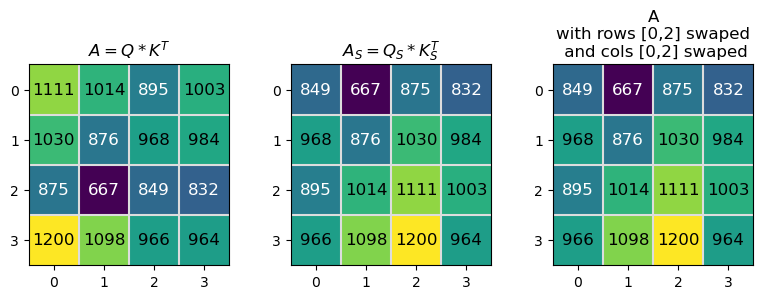

In [20]:
# Compute A (attention)
A = Q @ K.transpose()
swapA = swapQ @ swapK.transpose()
modA = copy.deepcopy(A)
modA[[0,2]] = modA[[2,0]] #swap rows
modA[:, [2, 0]] = modA[:, [0, 2]] #swap cols

# Note that A_s and A_swapped plot are the same
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
fig.tight_layout(pad=1.0)
plt.subplot(1, 3, 1)
mat_plot(A, r'$A = Q*K^T$')
plt.subplot(1, 3, 2)
mat_plot(swapA, r'$A_S = Q_S * K_S^T$')
plt.subplot(1, 3, 3)
mat_plot(modA, 'A\nwith rows [0,2] swaped\n and cols [0,2] swaped')
#plt.savefig(os.path.join(figure_path, 'AQKs.png'), bbox_inches='tight')

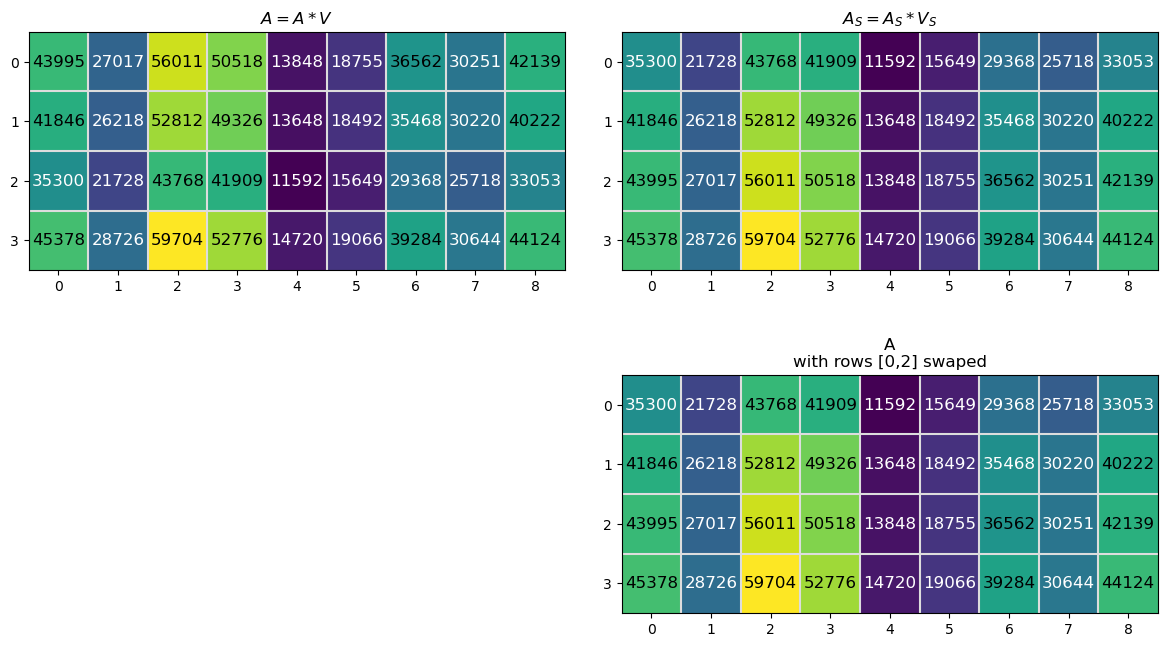

In [21]:
# Multiply by V
A = A @ V
swapA = swapA @ swapV
modA = copy.deepcopy(A)
modA[[0,2]] = modA[[2,0]] #swap rows

# Note that A_s and A_swapped plot are the same
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
fig.tight_layout(pad=1.0)
plt.subplot(2, 2, 1)
mat_plot(A, r'$A = A*V$')
plt.subplot(2, 2, 2)
mat_plot(swapA, r'$A_S = A_S * V_S$')
plt.subplot(2, 2, 4)
mat_plot(modA, 'A\nwith rows [0,2] swaped')
axs[1,0].axis('off');
#plt.savefig(os.path.join(figure_path, 'AVAs.png'), bbox_inches='tight')

# Position Embedding
Not clear evidence of one embedding method over other


In [22]:
# Sinsuiod embedding

def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token
            
        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    # theta_ij = i / 10000^(2jd)^-1
    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])

    # PE_(i, 2j) = sin(theta_ij)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # PE_(i, 2j+1) = sin(theta_ij)
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

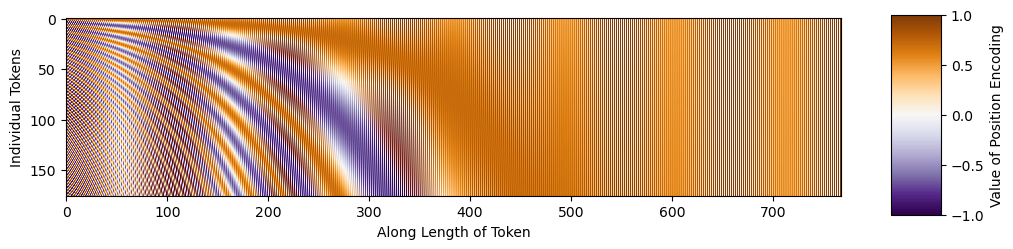

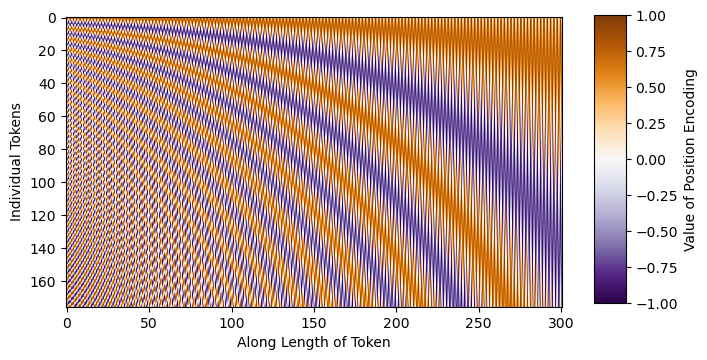

In [29]:
PE = get_sinusoid_encoding(num_tokens=176, token_len=768)

# Display token image
fig = plt.figure(figsize=(10, 8))
plt.imshow(PE[0, :, :], cmap='PuOr_r')
plt.xlabel('Along Length of Token')
plt.ylabel('Individual Tokens');
cbar_ax = fig.add_axes([0.95, .36, 0.05, 0.25])
plt.clim([-1, 1])
plt.colorbar(label='Value of Position Encoding', cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'fullPE.png'), bbox_inches='tight')

# Zoom into plot
fig = plt.figure()
plt.imshow(PE[0, :, 0:301], cmap='PuOr_r')
plt.xlabel('Along Length of Token')
plt.ylabel('Individual Tokens');
cbar_ax = fig.add_axes([0.95, .2, 0.05, 0.6])
plt.clim([-1, 1])
plt.colorbar(label='Value of Position Encoding', cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'zoomedinPE.png'), bbox_inches='tight')

# Apply Position Embedding to Token

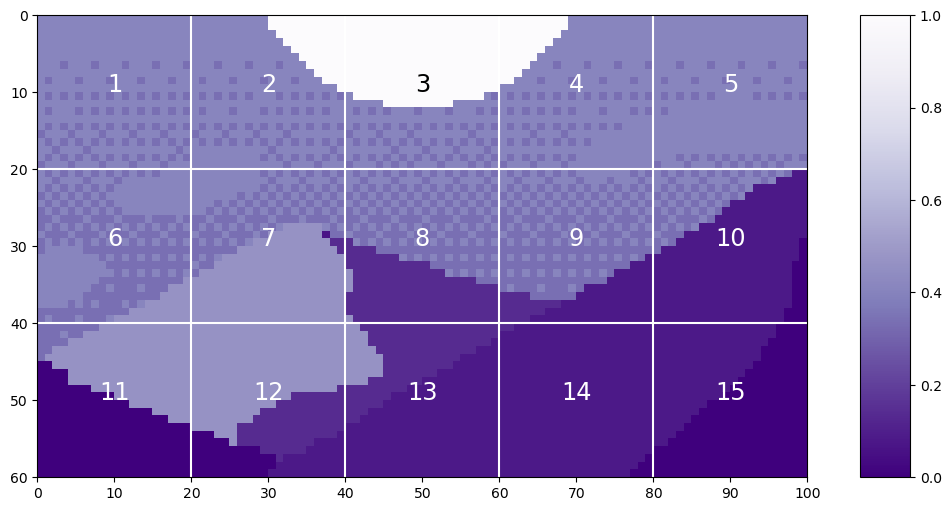

In [30]:
fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center')
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountain_patches_w_colorbar.png'), bbox_inches='tight')

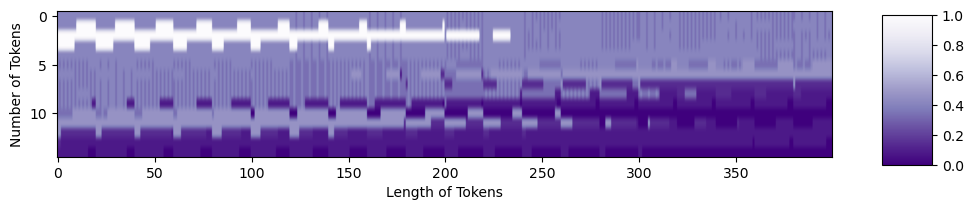

In [31]:
# Display tokenization
patch = np.zeros((P,P))
tokens = np.zeros((N, P**2))
for i in range(N):
    patch = mountains[top_y[i]:bottom_y[i], left_x[i]:right_x[i]]
    tokens[i, :] = patch.flatten()

fig = plt.figure(figsize=(10,6))
plt.imshow(tokens, aspect=5, cmap='Purples_r')
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
cbar_ax = fig.add_axes([0.95, .36, 0.05, 0.25])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountain_tokens_matrix.png'), bbox_inches='tight')

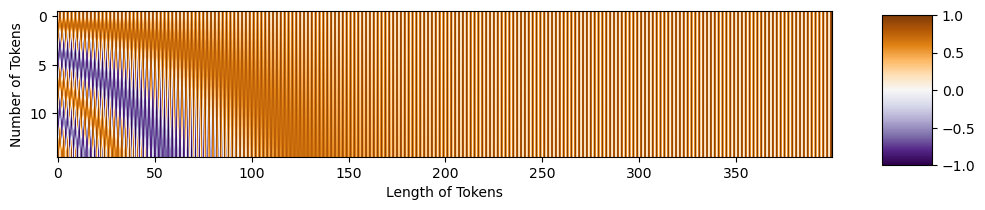

In [32]:
# Make into sinusoid shape
PE = get_sinusoid_encoding(num_tokens=15, token_len=400).numpy()[0,:,:]
fig = plt.figure(figsize=(10,6))
plt.imshow(PE, aspect=5, cmap='PuOr_r')
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
cbar_ax = fig.add_axes([0.95, .36, 0.05, 0.25])
plt.clim([-1, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountainsPE.png'), bbox_inches='tight')

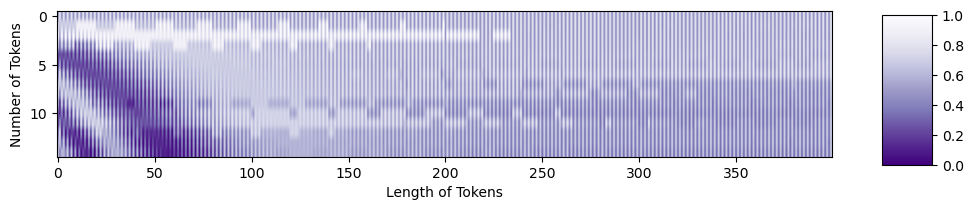

In [34]:
# Show in less clear coloring from before
mountainsPE = tokens + PE
rescaled_mountainsPE = (mountainsPE - np.min(mountainsPE)) / (np.max(mountainsPE) - np.min(mountainsPE))

fig = plt.figure(figsize=(10,6))
plt.imshow(rescaled_mountainsPE, aspect=5, cmap='Purples_r')
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
cbar_ax = fig.add_axes([0.95, .36, 0.05, 0.25])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains_plus_PE.png'), bbox_inches='tight')